In [1]:
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
from Bio import SeqIO
import pandas as pd
import seaborn as sns
%matplotlib inline

/home/ubuntu/tools/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def checkSlash(directory):
    if directory[-1] != '/':
        directory = directory + '/'
    return directory

def getAmphoraDNA(contigDir, amphoraDir, parallel):
    outFileName = amphoraDir.replace('/', '_DNA.sh')
    outFile = open(outFileName, 'w')
    outFile.write('#!/bin/bash\n#Amphora2 DNA sequence recovery commands\n\n')
    for subdir, dirs, files in os.walk(amphoraDir):
        for d in dirs:
            sampleID = d
            contigFile = contigDir + d + '_contigs.fna'
            outFile.write('./scripts/amphora_getDNA.py -a ' + \
                          amphoraDir + d + ' -c ' + contigFile + '\n')
    outFile.close()
    os.system('chmod +x ' + outFileName)
    os.system('cat ' + outFileName + ' | parallel --verbose -j ' + \
              str(parallel))

In [3]:
###GET_DNA
contigDir = '08_clean_contigs/'
amphoraDir = '09_amphora2/'
parallel = 38
#getAmphoraDNA(contigDir, amphoraDir, parallel)

In [46]:
#In this dataset, 30 genes appear in all samples
def formatDNA(inDir, outDir):
    outDir = checkSlash(outDir)
    if not os.path.exists(outDir):
        os.makedirs(outDir)
    ####
    #Build collection of which functional genes are in which samples
    #fxnalGenes = {gene name: list of samples that have it}
    fxnalGenes = {}
    numGenomes = 0
    for subdir, dirs, files in os.walk(inDir):
        for d in dirs:
            numGenomes += 1
            for f in os.listdir(inDir + d):
                if '.fa' in f:
                    gene = f.replace('.fa', '')
                    if gene not in fxnalGenes:
                        fxnalGenes[gene] = [d]
                    else:
                        fxnalGenes[gene].append(d)
    ####
    #Only keep genes that exist in all samples
    #Also edit to remove short versions of the genes
    for gene in fxnalGenes:
        if len(fxnalGenes[gene]) != numGenomes:
            continue
        geneFile = open(outDir + gene + '_dna.fa', 'w')
        for d in fxnalGenes[gene]:
            records = SeqIO.parse(inDir + d + '/' + gene + '.fa', 'fasta')
            maxHeader = ''
            maxSeq = ''
            for r in records:
                if len(r.seq) > len(maxSeq):
                    maxHeader = r.id
                    maxSeq = str(r.seq)
            geneFile.write('>' + d + ' ' + maxHeader + '\n')
            geneFile.write(maxSeq + '\n')
        geneFile.close()
    return numGenomes

In [47]:
inDir = '09_amphora2/'
outDir = '10_amphora_aligned_DNA/'
numGenomes = formatDNA(inDir, outDir)
print('Number of genomes: ' + str(numGenomes))

Number of genomes: 265


In [4]:
def alignDNA(inDir, parallel):
    #Align DNA sequences with Muscle
    #Create executable file to run in parallel
    outFileName = inDir.replace('/', '_alignDNA.sh')
    outFile = open(outFileName, 'w')
    outFile.write('#!/bin/bash\n#Amphora2 DNA alignment commands\n\n')
    for f in os.listdir(inDir):
        if '.fa' in f:
            outFile.write('muscle -in ' + inDir + f + ' -fastaout ' + \
                          inDir + f.replace('.fa', '_align.fa') + \
                          '\n')
    outFile.close()
    os.system('chmod +x ' + outFileName)
    os.system('cat ' + outFileName + ' | parallel --verbose -j ' + \
              str(parallel))

In [5]:
inDir = '10_amphora_aligned_DNA/'
parallel = 38
#alignDNA(inDir, parallel)

In [49]:
#Some samples appeared to fail alignment, are dropped out of analysis
def concatAlignments(inDir, numGenomes, outFile):
    if os.path.exists(outFile):
        os.system('rm ' + outFile)
    inDir = checkSlash(inDir)
    geneDict = {}
    for f in os.listdir(inDir):
        if '_dna_align.fa' in f:
            gene = f.replace('_dna_align.fa', '')
            geneDict[gene] = []
            records = list(SeqIO.parse(inDir + f, 'fasta'))
            for r in records:
                geneDict[gene].append(r.id)
    alignDict = {}
    for f in os.listdir(inDir):
        if '_dna_align.fa' in f:
            gene = f.replace('_dna_align.fa', '')
            if len(geneDict[gene]) == numGenomes:
                records = list(SeqIO.parse(inDir + f, 'fasta'))
                print(f + ': ' + str(len(records)))
                for r in records:
                    if r.id in alignDict:
                        alignDict[r.id] += r.seq
                    else:
                        alignDict[r.id] = r.seq
    outF = open(outFile, 'w')
    for s in alignDict:
        outF.write('>' + s + '\n')
        outF.write(str(alignDict[s]) + '\n')
    outF.close()

In [50]:
inDir = '10_amphora_aligned_DNA/'
outFile = inDir + 'all_concatenated_dna_align.fa'
#concatAlignments(inDir, numGenomes, outFile)

rplM_dna_align.fa: 265
rpsM_dna_align.fa: 265
rplK_dna_align.fa: 265
rplS_dna_align.fa: 265
infC_dna_align.fa: 265
rplB_dna_align.fa: 265


In [11]:
inDir = '10_amphora_aligned_DNA/'
inFile = inDir + 'all_concatenated_dna_align.fa'
records = list(SeqIO.parse(inFile, 'fasta'))
alignmentLen = len(records[0].seq)
print('Length of alignment, including gaps: ' + str(alignmentLen))

Length of alignment, including gaps: 9335


In [71]:
def buildPairwiseDiffs(inFile):
    records = list(SeqIO.parse(inFile, 'fasta'))
    rList = []
    for r in records:
        rList.append(r.id)
    df = pd.DataFrame(index=rList, columns=rList)
    for r1 in records:
        for r2 in records:
            #count = 0
            #i = 0
            #for i, base1 in enumerate(str(r1.seq)):
            #    if base1 != str(r2.seq)[i]:
            #        count += 1
            count = sum(1 for a, b in zip(r1.seq, r2.seq) if a != b)
            df.set_value(r1.id, r2.id, count)
    return df

In [72]:
inFile = inDir + 'all_concatenated_dna_align.fa'
df = buildPairwiseDiffs(inFile)
df.to_csv(inDir + 'pairwise_matrix.txt', sep = '\t')
df

,D17-102199,D17-102246,D17-102247,D17-102248,D17-102279,D17-102278,D17-102249,D17-102275,D17-102274,D17-102277,...,D17-102100,D17-102068,D17-102069,D17-102064,D17-102065,D17-102067,D17-102060,D17-102061,D17-102062,D17-102063
D17-102199,0,1694,1694,2207,1441,1355,3134,1860,1886,2119,...,2045,1730,1730,1698,1708,1709,1694,1710,1709,1701
D17-102246,1694,0,0,1518,1141,1199,2830,1816,1813,2140,...,1709,152,153,119,114,113,176,130,113,191
D17-102247,1694,0,0,1518,1141,1199,2830,1816,1813,2140,...,1709,152,153,119,114,113,176,130,113,191
D17-102248,2207,1518,1518,0,1740,1780,3150,2375,2381,2675,...,2059,1545,1547,1534,1506,1504,1528,1518,1504,1523
D17-102279,1441,1141,1141,1740,0,889,2800,1465,1464,1988,...,1747,1182,1182,1153,1149,1149,1150,1152,1149,1154
D17-102278,1355,1199,1199,1780,889,0,2708,858,869,1861,...,1712,1248,1243,1219,1216,1214,1205,1216,1214,1205
D17-102249,3134,2830,2830,3150,2800,2708,0,3076,3111,3520,...,2381,2819,2816,2832,2827,2827,2830,2845,2827,2829
D17-102275,1860,1816,1816,2375,1465,858,3076,0,467,2243,...,2127,1858,1858,1833,1835,1834,1822,1826,1834,1820
D17-102274,1886,1813,1813,2381,1464,869,3111,467,0,2305,...,2156,1855,1855,1830,1832,1831,1819,1823,1831,1817
D17-102277,2119,2140,2140,2675,1988,1861,3520,2243,2305,0,...,2511,2189,2185,2144,2154,2156,2140,2153,2156,2146


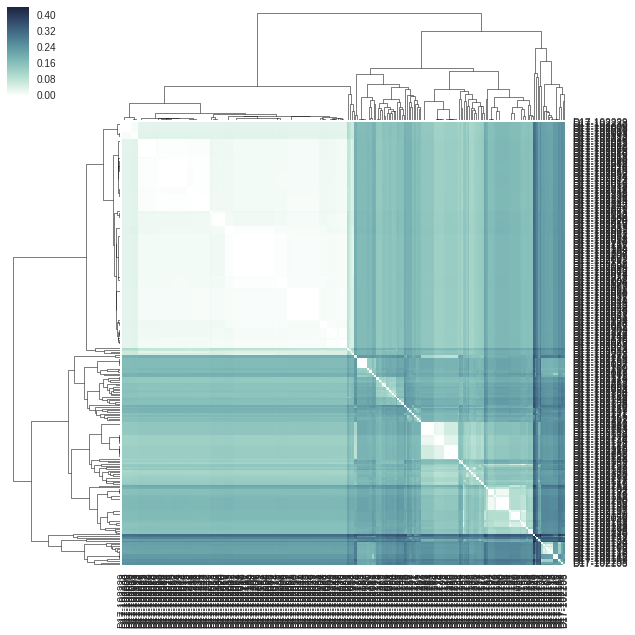

In [20]:
inFile = '10_amphora_aligned_DNA/pairwise_matrix.txt'
df = pd.read_csv(inFile, sep = '\t', index_col=0)
df_per_site = df.divide(alignmentLen)

#Plot heatmap of substitutions per site
outPDF = '10_amphora_aligned_DNA/pairwise_matrix.pdf'
cmap = sns.cubehelix_palette(as_cmap=True, rot=-.3, light=1)
fig = sns.clustermap(df_per_site, cmap=cmap)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
fig.savefig(outPDF)